In [21]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_datareader import DataReader
from datetime import datetime
import scipy.stats as ss
import yfinance as yf
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
start_date = datetime(2020,1,1)
end_date = datetime(2024,8,31)

In [22]:
# Preliminary Analysis 1
stock_symbol = "PANW"
stock_1 = yf.download(stock_symbol,start_date ,end_date)

# Discussion 1
adj_close = stock_1['Adj Close'].values
print('sample mean',np.mean(adj_close))
print('sample standard deviation',np.std(adj_close))
print('sample skewness: ',ss.skew(adj_close, axis=0, bias=True))
print('sample kurtosis: ',ss.kurtosis(adj_close, axis=0, bias=True) + 3)
print(stock_1.head())
print(stock_1['Adj Close'].describe()) # summary statistics

[*********************100%***********************]  1 of 1 completed

sample mean 175.56467342214242
sample standard deviation 78.6388706608656
sample skewness:  0.5515489943211344
sample kurtosis:  2.4906666224949117
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2020-01-02  77.746666  78.646667  77.650002  78.470001  78.470001  2835900
2020-01-03  77.646667  78.996666  77.646667  78.943336  78.943336  2229600
2020-01-06  78.783333  80.180000  78.570000  80.086670  80.086670  3342600
2020-01-07  80.086670  80.833336  79.776665  80.546669  80.546669  3384900
2020-01-08  79.333336  79.919998  78.926666  79.523331  79.523331  3157200
count    1174.000000
mean      175.564673
std        78.672384
min        44.193333
25%       117.724998
50%       167.468330
75%       227.447498
max       376.899994
Name: Adj Close, dtype: float64


/var/folders/p3/rcvq04y148z9r_2p528s4znc0000gn/T/ipykernel_1468/24604883.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(adj_close, shade=True, color='blue')


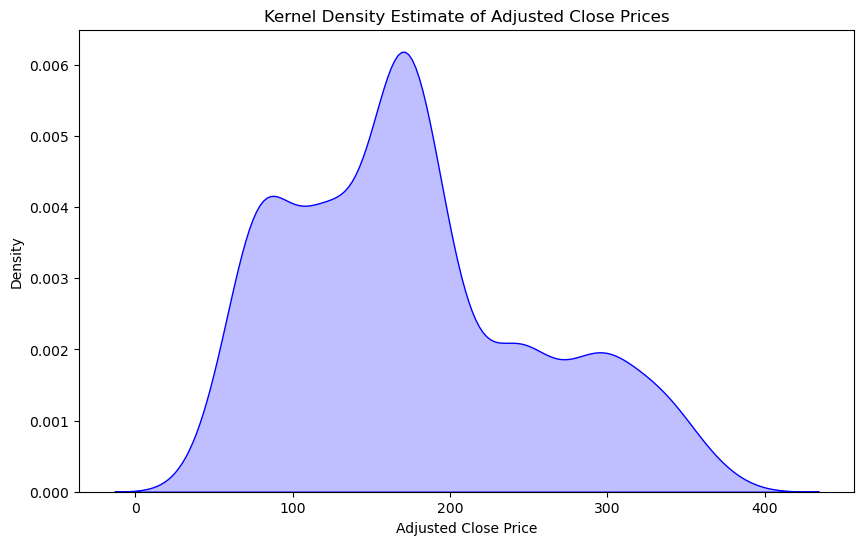

In [23]:
plt.figure(figsize=(10,6))
sns.kdeplot(adj_close, shade=True, color='blue')
plt.title('Kernel Density Estimate of Adjusted Close Prices')
plt.xlabel('Adjusted Close Price')
plt.ylabel('Density')
plt.show()


In [24]:
"Bootstrap"
T= adj_close.shape[0]
B = 1000 # 5000, 100000 [250 9750]
mu_boot = np.zeros(B)
se_boot = np.zeros(B)
x_boot_std = np.zeros(B)
for i in range(0, B):
     x_boot = adj_close[np.random.choice(T,T)]
     mu_boot[i] = np.mean(x_boot)
     se_boot[i] = np.std(x_boot)/np.sqrt(T) # std of mu_boot
     x_boot_std[i] = np.std(x_boot) # std of x_boot
     # CLT: std(x_boost) = sqrt(T)*std(mu_boot)
mu_boot = np.sort(mu_boot)
se_boot = np.sort(se_boot)
xboot_std = np.sort(x_boot_std)
print("Statistics about the Mean")
print("95% confidence interval of mu_boot:", mu_boot[25], mu_boot[975])
print("95% confidence interval of std_boot of mu :", se_boot[25], se_boot[975])
print("\n")
print("Statistics about the Sample")
print(f"95% confidence interval of {stock_symbol} stock price std (method 1):", se_boot[25]*np.sqrt(T), se_boot[975]*np.sqrt(T))
print(f"95% confidence interval of {stock_symbol} stock price std (method 2):", xboot_std[25], xboot_std[975])

Statistics about the Mean
95% confidence interval of mu_boot: 170.8369646673511 180.02394081908557
95% confidence interval of std_boot of mu : 2.214509789826373 2.3710571674782583


Statistics about the Sample
95% confidence interval of PANW stock price std (method 1): 75.8772623204347 81.24115210508974
95% confidence interval of PANW stock price std (method 2): 75.8772623204347 81.24115210508974


sample mean: $175.56467342214242
sample standard deviation: $78.6388706608656


/var/folders/p3/rcvq04y148z9r_2p528s4znc0000gn/T/ipykernel_1468/622020494.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulatedPrice[t] = p1*(u<p)+p2*(u>=p);


confidence interval of mu_mc: 185.24916073237407 194.65519203237926


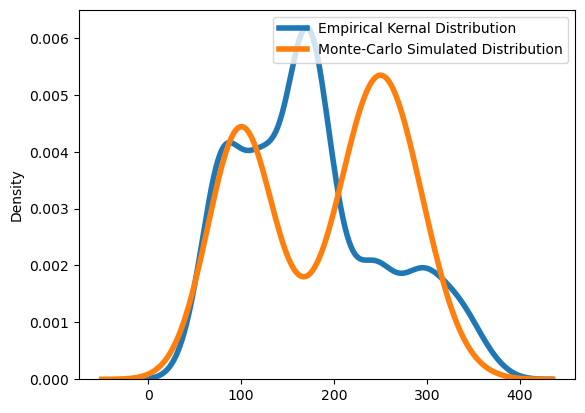

In [50]:
T = len(adj_close) # number of trading days
mu = np.mean(adj_close)
se = np.std(adj_close)
print(f"sample mean: ${mu}")
print(f"sample standard deviation: ${se}")

# observe kde plot and assign values to key parameters
mu_1 = 100# mean of the first component distribution
sigma_1 = 30 # standard deviation of the first component distribution
mu_2 = 250 # mean of the second component distribution
sigma_2 = 40 # standard deviation of the second component distribution
p = 0.4

def generateEmpiricalDist(mu_1, sigma_1, mu_2, sigma_2, p, T):
    #Normal Mixture
    simulatedPrice = np.zeros(T-1);
    for t in range(0,T-1):
        p1 = mu_1 + sigma_1*np.random.normal(0,1,1);
        p2 = mu_2 + sigma_2*np.random.normal(0,1,1);
        u = np.random.uniform(0,1,1);
        simulatedPrice[t] = p1*(u<p)+p2*(u>=p);

    return simulatedPrice


T = adj_close.shape[0]
M = 1000
mu_mc = np.zeros(M)
y_mc = 0
for i in range(0, M):
    simulatedPrice = generateEmpiricalDist(mu_1, sigma_1, mu_2, sigma_2, p, T)
    mu_mc[i] = np.mean(simulatedPrice)
    y_mc += np.sort(simulatedPrice)

y_mc = y_mc/M
mu_mc = np.sort(mu_mc)

print("confidence interval of mu_mc:", mu_mc[25], mu_mc[975])

# Visualization
fig, ax = plt.subplots()
sns.kdeplot(data=adj_close, linewidth=4) # the blue line
sns.kdeplot(data=y_mc, linewidth=4) # the orange line
ax.legend(['Empirical Kernal Distribution', 'Monte-Carlo Simulated Distribution'])

GMM Parameters:
Component 1: Mean = 140.41, Variance = 2336.72, Weight = 0.76
Component 2: Mean = 288.07, Variance = 1885.98, Weight = 0.24


/var/folders/p3/rcvq04y148z9r_2p528s4znc0000gn/T/ipykernel_1468/244527980.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(adj_close, shade=True, color='blue', label='Empirical KDE')


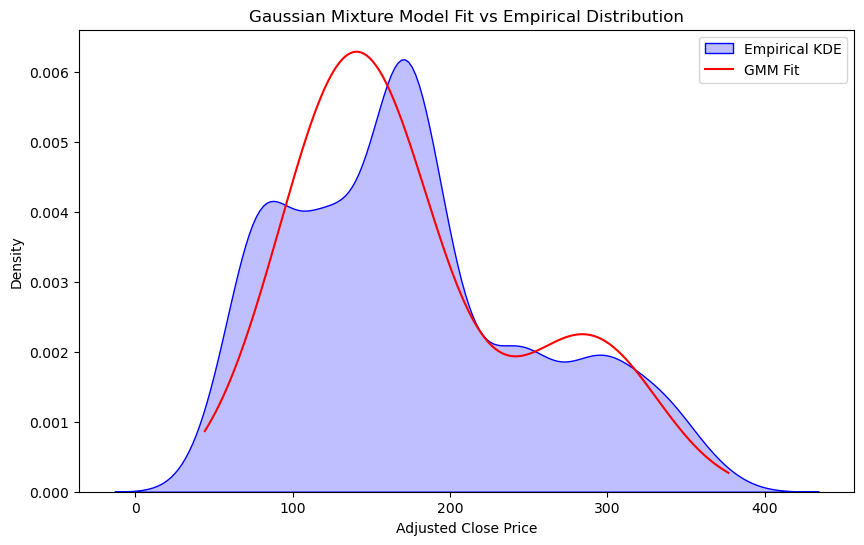

In [26]:
# Reshape data for GMM
data = adj_close.reshape(-1, 1)

# Fit GMM with 2 components
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data)

# Get the parameters
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()
weights = gmm.weights_.flatten()

print("GMM Parameters:")
for i in range(2):
    print(f"Component {i+1}: Mean = {means[i]:.2f}, Variance = {covariances[i]:.2f}, Weight = {weights[i]:.2f}")

# Plot the mixture model
x = np.linspace(adj_close.min(), adj_close.max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)

plt.figure(figsize=(10,6))
sns.kdeplot(adj_close, shade=True, color='blue', label='Empirical KDE')
plt.plot(x, pdf, color='red', label='GMM Fit')
plt.title('Gaussian Mixture Model Fit vs Empirical Distribution')
plt.xlabel('Adjusted Close Price')
plt.ylabel('Density')
plt.legend()
plt.show()


95% Confidence Interval for the Mean: [171.22, 180.52]


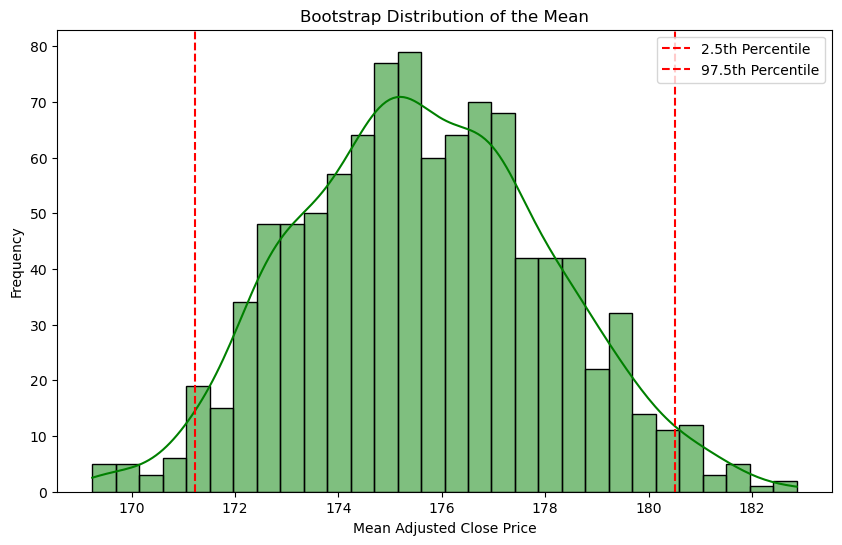

In [27]:
# Number of bootstrap samples
n_bootstraps = 1000
bootstrap_means = []

# Perform bootstrap
for _ in range(n_bootstraps):
    sample = resample(adj_close, replace=True, n_samples=len(adj_close))
    bootstrap_means.append(sample.mean())

# Calculate 95% confidence interval
conf_int = np.percentile(bootstrap_means, [2.5, 97.5])

print(f"95% Confidence Interval for the Mean: [{conf_int[0]:.2f}, {conf_int[1]:.2f}]")

# Plot the bootstrap distribution
plt.figure(figsize=(10,6))
sns.histplot(bootstrap_means, bins=30, kde=True, color='green')
plt.axvline(conf_int[0], color='red', linestyle='--', label='2.5th Percentile')
plt.axvline(conf_int[1], color='red', linestyle='--', label='97.5th Percentile')
plt.title('Bootstrap Distribution of the Mean')
plt.xlabel('Mean Adjusted Close Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()
